In [2]:
from datasets import load_dataset
labeled_ds = load_dataset("tianharjuno/twitter-parse", cache_dir="cache/", split="source_labeled")


In [3]:
relevant_ds = labeled_ds.filter(lambda x: x["relevant"]== True)

In [4]:
relevant_ds

Dataset({
    features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'relevant', 'sentiment'],
    num_rows: 147701
})

In [5]:
negative = relevant_ds.filter(lambda x: x["sentiment"] == 0)
neutral = relevant_ds.filter(lambda x: x["sentiment"] == 1)
positive = relevant_ds.filter(lambda x: x["sentiment"] == 2)


In [6]:
print(negative, neutral, positive)

Dataset({
    features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'relevant', 'sentiment'],
    num_rows: 104955
}) Dataset({
    features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'relevant', 'sentiment'],
    num_rows: 31335
}) Dataset({
    features: ['tweet_id', 'time', 'author', 'content', 'comment_count', 'repost_count', 'like_count', 'view_count', 'relevant', 'sentiment'],
    num_rows: 11411
})


In [7]:
import pandas as pd

# 1. Preprocessing: Time conversion and Label Mapping
# df = ds.to_pandas() # If not already a dataframe
df = relevant_ds.to_pandas()
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# Map integers to labels for clearer column names (Optional)
# This ensures your output columns are named 'negative', 'neutral', 'positive'
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
df['sentiment_label'] = df['sentiment'].map(sentiment_map)

# 2. Calculate Daily Sentiment Ratios (Distribution)
# This computes P(Sentiment | Day)
daily_ratios = pd.crosstab(
    index=df['date'],
    columns=df['sentiment_label'],
    normalize='index' # Normalizes across the row so sum is 1.0
)

# Ensure all columns exist (fill with 0 if a sentiment is missing on some days)
expected_cols = ['negative', 'neutral', 'positive']
for col in expected_cols:
    if col not in daily_ratios.columns:
        daily_ratios[col] = 0.0

# Reorder for consistency
daily_ratios = daily_ratios[expected_cols]

# 3. (Optional) Calculate a Single Net Sentiment Metric
# Common research metric: (Positive - Negative)
# Since these are ratios, this value ranges from -1 (All Negative) to +1 (All Positive)
daily_ratios['net_sentiment'] = daily_ratios['positive'] - daily_ratios['negative']

print(daily_ratios.head())

sentiment_label  negative  neutral  positive  net_sentiment
date                                                       
2009-08-06            0.0      1.0       0.0            0.0
2009-09-27            1.0      0.0       0.0           -1.0
2009-11-24            1.0      0.0       0.0           -1.0
2009-11-27            1.0      0.0       0.0           -1.0
2009-11-29            1.0      0.0       0.0           -1.0


In [8]:
import pandas as pd
import numpy as np

# 1. Load and Preprocess (Assuming relevant_ds is your HuggingFace dataset)
df = relevant_ds.to_pandas()
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# 2. Resample by Week to get Raw Counts for each sentiment
# This creates a dataframe with columns: 0 (Neg), 1 (Neu), 2 (Pos)
weekly_counts = df.groupby('sentiment')['content'].resample('W').count().unstack(level=0)

# Fill zeros for weeks with no tweets
weekly_counts = weekly_counts.fillna(0)

# Rename columns for clarity
sentiment_map = {0: 'count_neg', 1: 'count_neu', 2: 'count_pos'}
weekly_counts.rename(columns=sentiment_map, inplace=True)

# 3. Calculate Derived Metrics
# Total Volume per week
weekly_counts['relevant'] = weekly_counts['count_pos'] + weekly_counts['count_neu'] + weekly_counts['count_neg']

# Net Sentiment Score (Formula: (Pos - Neg) / Total)
# Range: -1.0 (All Negative) to +1.0 (All Positive)
# We use np.where to handle division by zero (empty weeks)
weekly_counts['sentiment_score'] = np.where(
    weekly_counts['relevant'] > 0,
    (weekly_counts['count_pos'] - weekly_counts['count_neg']) / weekly_counts['relevant'],
    0.0 # Default to neutral if no data
)

# 4. Apply Bayesian Weighting (Normalization by Data Availability)
# This dampens the score if volume is low
C = 500 # Confidence Threshold
weekly_counts['trust_factor'] = weekly_counts['relevant'] / (weekly_counts['relevant'] + C)
weekly_counts['weighted_sentiment'] = weekly_counts['sentiment_score'] * weekly_counts['trust_factor']

# 5. Filter for Date Range (Optional)
start_date = '2023-01-01'
end_data = '2025-05-31'
weekly_data = weekly_counts[(weekly_counts.index >= start_date) & (weekly_counts.index <= end_data)].copy()

# Output check
print(weekly_data[['relevant', 'sentiment_score', 'weighted_sentiment']].tail())

sentiment   relevant  sentiment_score  weighted_sentiment
time                                                     
2025-04-27    2785.0        -0.077917           -0.066058
2025-05-04    1673.0        -0.215182           -0.165670
2025-05-11    1392.0        -0.244971           -0.180233
2025-05-18    1419.0        -0.445384           -0.329338
2025-05-25    1310.0        -0.409160           -0.296133


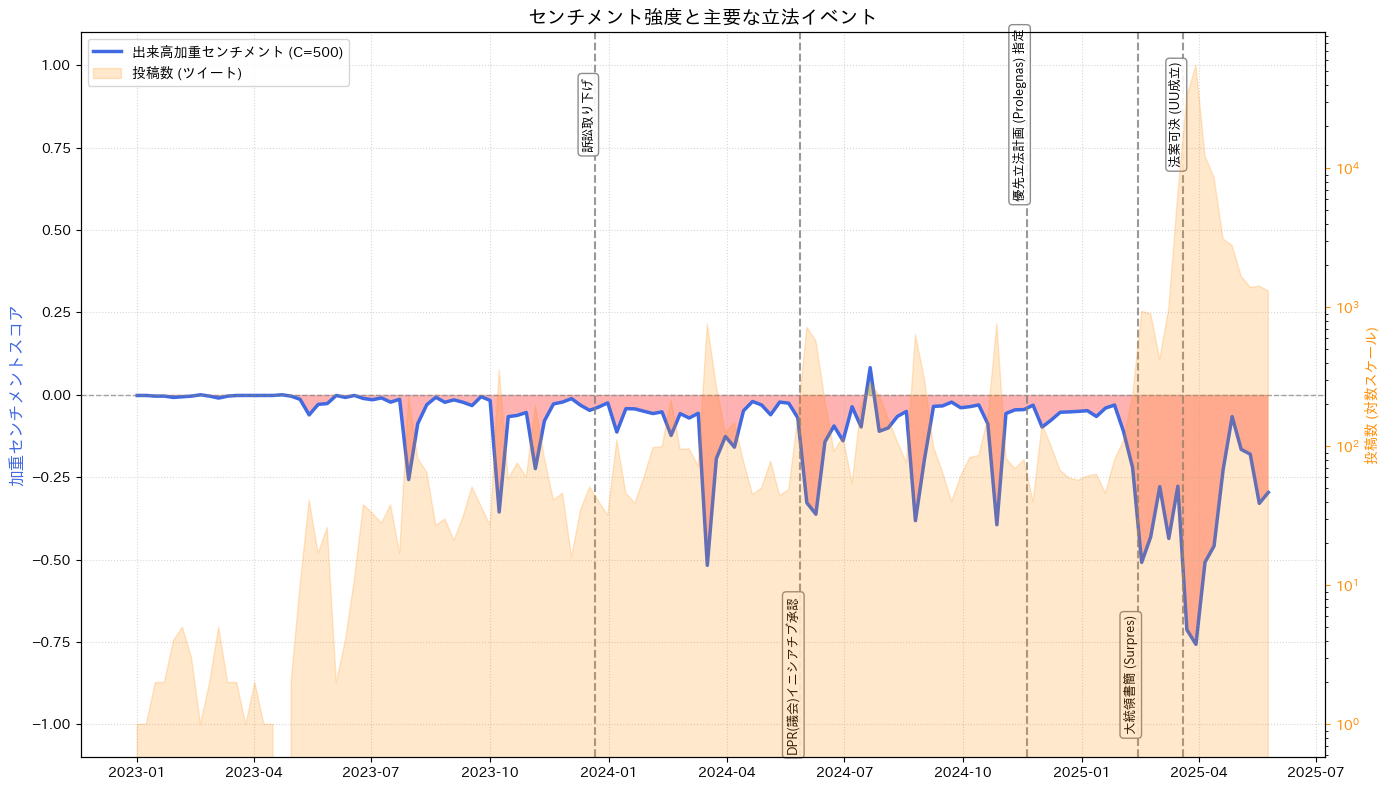

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib
# --- O. Ensure Light Theme & Japanese Font Support ---
plt.style.use('default')
plt.rcParams['font.family'] = 'IPAexGothic'  # Example Japanese font; ensure it's installed

# --- 1. Event Data Array (Translated) ---
key_events = [
    {"date": "2023-12-21", "label": "訴訟取り下げ"}, 
    {"date": "2024-05-28", "label": "DPR(議会)イニシアチブ承認"}, 
    {"date": "2024-11-19", "label": "優先立法計画 (Prolegnas) 指定"}, 
    {"date": "2025-02-13", "label": "大統領書簡 (Surpres)"}, 
    {"date": "2025-03-20", "label": "法案可決 (UU成立)"}, 
    {"date": "2025-09-17", "label": "憲法裁判所 (MK) 最終判決"} 
]

# --- 2. Processing (Unchanged Logic) ---
# Assuming 'weekly_data' is already loaded in your environment
C = 500
weekly_data['trust_factor'] = weekly_data['relevant'] / (weekly_data['relevant'] + C)
weekly_data['weighted_sentiment'] = weekly_data['sentiment_score'] * weekly_data['trust_factor']

# --- 3. Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Weighted Sentiment
ax1.plot(weekly_data.index,
         weekly_data['weighted_sentiment'],
         label=f'出来高加重センチメント (C={C})', # Volume-Weighted Sentiment
         color='royalblue',
         linewidth=2.5,
         zorder=2)

# Zero Line
ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Fill Areas
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] > 0),
                 facecolor='green', alpha=0.3, interpolate=True)
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] <= 0),
                 facecolor='red', alpha=0.3, interpolate=True)

ax1.set_ylabel('加重センチメントスコア', color='royalblue', fontsize=12) # Weighted Sentiment Score
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True, linestyle=':', alpha=0.5)

# Plot Volume (Log Scale)
ax2 = ax1.twinx()
ax2.fill_between(weekly_data.index,
                 weekly_data['relevant'],
                 color='darkorange',
                 alpha=0.2,
                 label='投稿数 (ツイート)') # Tweet Volume
ax2.set_yscale('log')
ax2.set_ylabel('投稿数 (対数スケール)', color='darkorange') # Volume (Log Scale)
ax2.tick_params(axis='y', colors='darkorange')

# --- NEW: Add Vertical Bars for Events ---
for i, event in enumerate(key_events):
    event_date = pd.to_datetime(event['date'])

    if event_date >= weekly_data.index.min() and event_date <= weekly_data.index.max():
        # 1. Draw Vertical Line
        ax1.axvline(x=event_date, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

        # 2. Add Label
        y_pos = 0.85 if i % 2 == 0 else -0.85

        ax1.text(x=event_date,
                 y=y_pos,
                 s=event['label'],
                 rotation=90,
                 color='black',
                 fontsize=9,
                 ha='right',
                 va='center',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.title('センチメント強度と主要な立法イベント', fontsize=14) # Sentiment Intensity vs Events

# Combine Legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

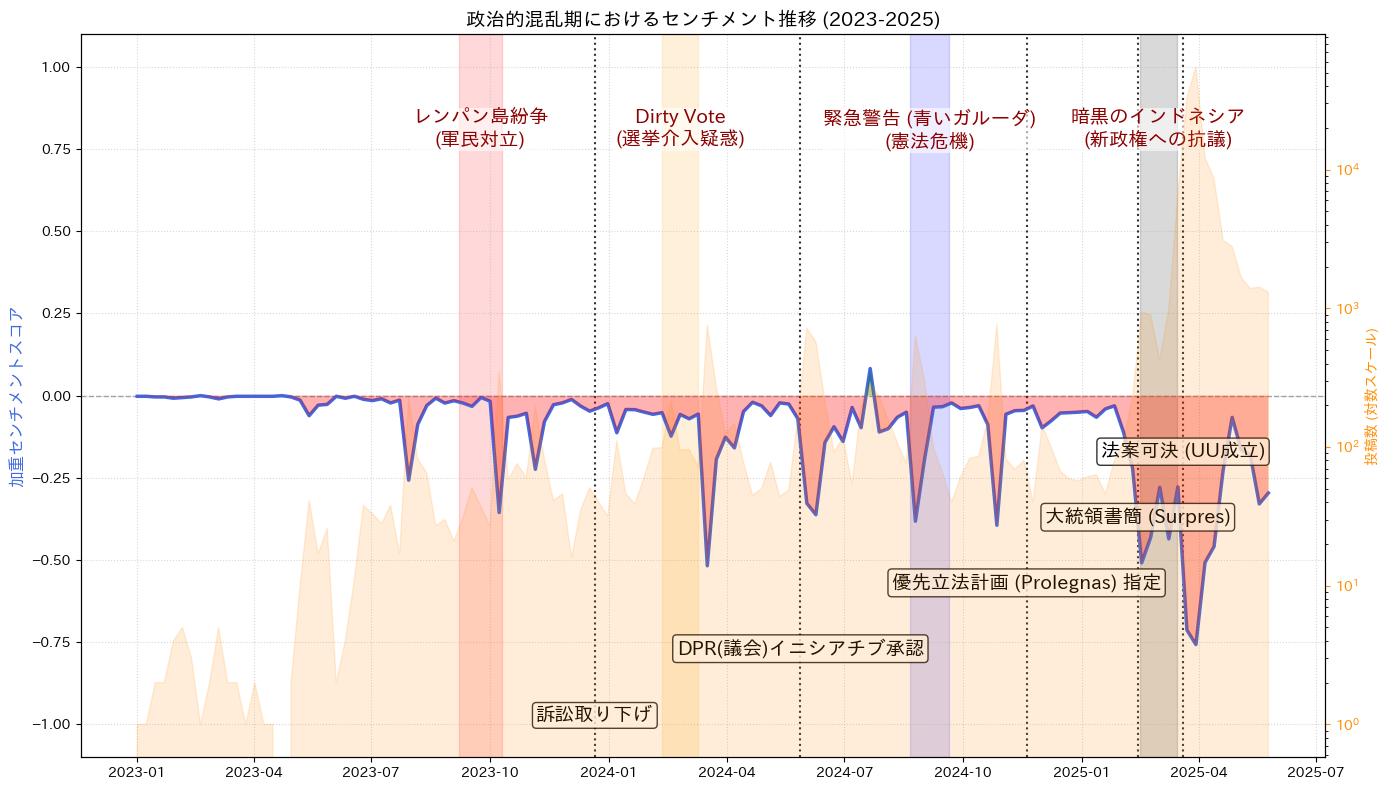

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib # Ensure Japanese font is loaded

# --- O. Setup & Theme ---
plt.style.use('default')
plt.rcParams['font.family'] = 'IPAexGothic'  # Example Japanese font; ensure 
point_events = [
    {"date": "2023-12-21", "label": "訴訟取り下げ"}, 
    {"date": "2024-05-28", "label": "DPR(議会)イニシアチブ承認"}, 
    {"date": "2024-11-19", "label": "優先立法計画 (Prolegnas) 指定"}, 
    {"date": "2025-02-13", "label": "大統領書簡 (Surpres)"}, 
    {"date": "2025-03-20", "label": "法案可決 (UU成立)"}, 
    {"date": "2025-09-17", "label": "憲法裁判所 (MK) 最終判決"} 
]

# B. Period Events (Durations - Shaded Areas)
# These are the viral discourses/protests.
period_events = [
    {
        # Rempang Eco-City Conflict
        # Started with the Sep 7 clashes, discourse lasted until mid-October
        "start": "2023-09-07", 
        "end": "2023-10-10", 
        "label": "レンパン島紛争\n(軍民対立)", 
        "color": "red"
    },
    {
        # Dirty Vote / Election Fraud Discourse
        # Started with the movie release, continued through the election count (Feb 14-Mar 20)
        "start": "2024-02-11", 
        "end": "2024-03-10", 
        "label": "Dirty Vote\n(選挙介入疑惑)", 
        "color": "orange"
    },
    {
        # Peringatan Darurat (Blue Garuda)
        # Started Aug 21. The "Constitutional Crisis" discourse lingered 
        # as the "Fufufafa" scandal and inauguration preparations began.
        "start": "2024-08-21", 
        "end": "2024-09-20", 
        "label": "緊急警告 (青いガルーダ)\n(憲法危機)", 
        "color": "blue" 
    },
    {
        # Indonesia Gelap (Dark Indonesia)
        # The final wave of protest leading up to the Ratification.
        # Placing this right before the March 20, 2025 ratification makes a strong visual story.
        "start": "2025-02-15", 
        "end": "2025-03-15", 
        "label": "暗黒のインドネシア\n(新政権への抗議)", 
        "color": "black" 
    }
]
# --- 2. Processing (Assumed Data) ---
# (Using your existing logic)
# Ensure weekly_data exists before running this part
if 'weekly_data' in locals():
    C = 500
    weekly_data['trust_factor'] = weekly_data['relevant'] / (weekly_data['relevant'] + C)
    weekly_data['weighted_sentiment'] = weekly_data['sentiment_score'] * weekly_data['trust_factor']
else:
    # Fallback for demonstration if data isn't loaded
    print("!! Data not found. Please load 'weekly_data' first. !!")

# --- 3. Plotting ---
fig, ax1 = plt.subplots(figsize=(14, 8))

# A. Plot Weighted Sentiment
ax1.plot(weekly_data.index,
         weekly_data['weighted_sentiment'],
         label=f'出来高加重センチメント (C={C})', 
         color='royalblue',
         linewidth=2.5,
         zorder=3) # Higher zorder to sit on top of shading

ax1.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.7)

# Fill Positive/Negative Areas
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] > 0),
                 facecolor='green', alpha=0.3, interpolate=True, zorder=3)
ax1.fill_between(weekly_data.index, weekly_data['weighted_sentiment'], 0,
                 where=(weekly_data['weighted_sentiment'] <= 0),
                 facecolor='red', alpha=0.3, interpolate=True, zorder=3)

# --- B. RENDER PERIOD EVENTS (SHADING) ---
for p in period_events:
    start = pd.to_datetime(p['start'])
    end = pd.to_datetime(p['end'])
    
    # Check if period overlaps with graph range
    if start <= weekly_data.index.max() and end >= weekly_data.index.min():
        # Draw the shaded box
        ax1.axvspan(start, end, 
                   color=p['color'], 
                   alpha=0.15, # Transparency (keep it low)
                   label='_nolegend_') # Don't add to legend to avoid clutter
        
        # Add Label at the top center of the period
        mid_point = start + (end - start) / 2
        ax1.text(mid_point, 
                 ax1.get_ylim()[1] * 7, # Position near top
                 p['label'], 
                 ha='center', va='top', 
                 fontsize=14, color='darkred', 
                 fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

# --- C. RENDER POINT EVENTS (LINES) ---
for i, event in enumerate(point_events):
    event_date = pd.to_datetime(event['date'])
    if event_date >= weekly_data.index.min() and event_date <= weekly_data.index.max():
        ax1.axvline(x=event_date, color='black', linestyle=':', linewidth=1.5, alpha=0.8)
        
        # Label for lines
        ax1.text(event_date, 
                 -1 + (i * 0.2), # Stagger heights at bottom
                 event['label'], 
                 rotation=0, 
                 ha='center', va='bottom', 
                 fontsize=14, 
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.8))

# Axis Settings
ax1.set_ylabel('加重センチメントスコア', color='royalblue', fontsize=12)
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True, linestyle=':', alpha=0.5)

# Secondary Axis (Volume)
ax2 = ax1.twinx()
ax2.fill_between(weekly_data.index,
                 weekly_data['relevant'],
                 color='darkorange',
                 alpha=0.15,
                 label='投稿数 (ツイート)')
ax2.set_yscale('log')
ax2.set_ylabel('投稿数 (対数スケール)', color='darkorange')
ax2.tick_params(axis='y', colors='darkorange')

plt.title('政治的混乱期におけるセンチメント推移 (2023-2025)', fontsize=14)
plt.tight_layout()
plt.show()